In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import aqi

%matplotlib inline

# Data preparation

## City centre

These AQI values were calculated by the World Air Quality Index Project using data recorded by the Welsh Government (Air Quality In Wales) in Cardiff city centre.

In [14]:
centre_data = pd.read_csv("data/cardiff-centre-AQI.csv")
centre_data['date'] = pd.to_datetime(centre_data['date'])
centre_data = centre_data.set_index('date')
centre_data = centre_data.sort_index()
cols = [' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']
centre_data[cols] = centre_data[cols].apply(pd.to_numeric, errors='coerce')
centre_data['centre_index'] = centre_data[cols].max(axis=1)
centre_data = centre_data.drop(cols, axis=1)
centre_data = centre_data.loc['2020-06-23':'2020-08-13']
centre_data.head()

,centre_index
date,
2020-06-23,57.0
2020-06-24,54.0
2020-06-25,50.0
2020-06-26,37.0
2020-06-27,23.0


## CSL

In [15]:
import aqi

csl_data = pd.read_csv("data/csl-data.csv")
cols = [c for c in csl_data.columns if 'AQI' not in c]
csl_data = csl_data[cols]
csl_data['timestamp'] = pd.to_datetime(csl_data['timestamp'],unit='s')
csl_data = csl_data.set_index('timestamp')
def conv_to_aqi(row):
    return int(aqi.to_aqi([
        (aqi.POLLUTANT_PM25, row.PM2_5),
        (aqi.POLLUTANT_PM10, row.PM10_0),
        (aqi.POLLUTANT_NO2_1H, row.NO2),
        (aqi.POLLUTANT_CO_8H, row.CO)
    ]))
csl_data = csl_data.resample('D').mean()
csl_data['csl_index'] = csl_data.apply(conv_to_aqi, axis=1)
csl_data = pd.DataFrame(csl_data['csl_index'])
csl_data.head()

,csl_index
timestamp,
2020-06-23,20
2020-06-24,40
2020-06-25,55
2020-06-26,48
2020-06-27,8


## Joining the data

In [48]:
data = centre_data.join(csl_data)
data.tail()

,centre_index,csl_index
date,,
2020-08-09,44.0,66
2020-08-10,67.0,84
2020-08-11,72.0,83
2020-08-12,66.0,74
2020-08-13,59.0,79


# Analysis

## Line graph

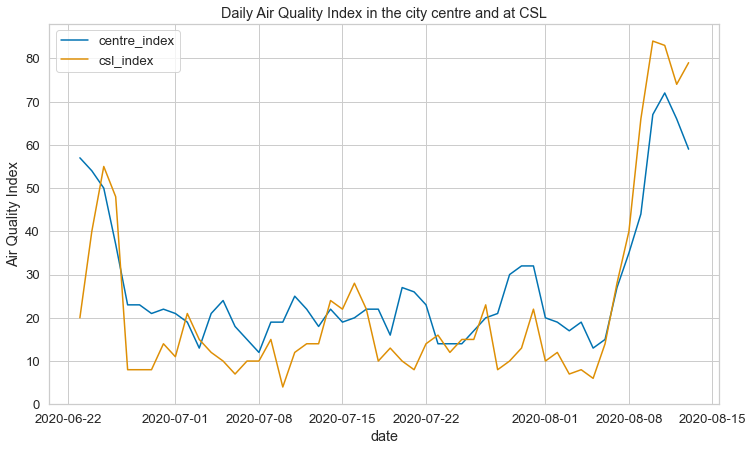

In [17]:
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")
sns.set_palette("colorblind")

plt.figure(figsize=(12, 7))
sns.lineplot(data=data, dashes=False)
plt.title("Daily Air Quality Index in the city centre and at CSL")
plt.ylabel("Air Quality Index");

We can see on the graph that the air quality index of measurements taken in the city centre and at the school are mostly relatively similar. The differences are likely to be because of the distance between the two monitors.

## Correlation coefficient

In [18]:
corr = data['csl_index'].corr(data['centre_index'])
print('Pearson correlation coefficient:', corr)

Pearson correlation coefficient: 0.8671121234253926


The Perason correlation coefficient measures the strength of a correlation between two variables, with 1 being a perfect positive correlation and -1 being a perfect negative correlation.

The high value of the measure shows that the averages of the readings of the two monitors are correlated together.

## Scatter graph

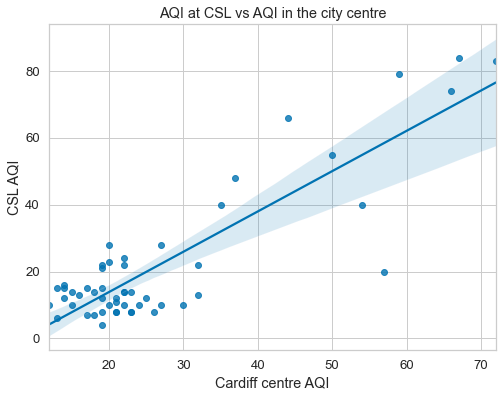

In [19]:
plt.figure(figsize=(8, 6))
sns.regplot(data=data, x='centre_index', y='csl_index')
plt.title("AQI at CSL vs AQI in the city centre")
plt.xlabel("Cardiff centre AQI")
plt.ylabel("CSL AQI");

The scatter graph also shows a correlation between the readings of the two monitors.

## Distribution

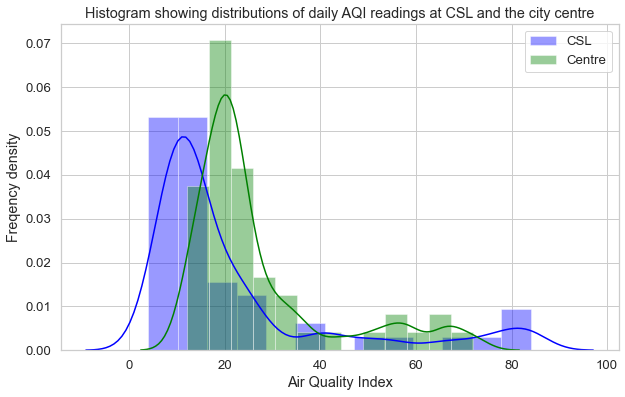

In [20]:
plt.figure(figsize=(10, 6))
sns.distplot(a=data['csl_index'], color='blue', label='CSL')
sns.distplot(a=data['centre_index'], color='green', label='Centre')
plt.ylabel("Freqency density")
plt.xlabel("Air Quality Index")
plt.title("Histogram showing distributions of daily AQI readings at CSL and the city centre")
plt.legend();

The histogram shows that the median for the air quality index at CSL is lower than the median for the city centre. This may be because Llandaff is a more residential area than the city centre and is hence likely to suffer from less road traffic.

However, the maximum for CSL is higher than the maximum for the city centre. This could be because the school is situated near a main road (A48), which would produce a lot of air pollution on busy days. In contrast, the monitor in the city centre is located in a pedestrianised area in Cathays further from a main road.